# Compare MendelImpute against Minimac4 and Beagle5 on simulated data

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using SparseArrays
using Plots

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/biona001/.julia/packages/Revise/439di/src/Revise.jl:1108
┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


# Simulate data

### Step 0. Install `msprime`

[msprime download Link](https://msprime.readthedocs.io/en/stable/installation.html).

Some people might need to activate conda environment via `conda config --set auto_activate_base True`. You can turn it off once simulation is done by executing `conda config --set auto_activate_base False`.


### Step 1. Simulate data in terminal

```
python3 msprime_script.py 4000 10000 5000000 2e-8 2e-8 2019 > full.vcf
```

Arguments: 
+ Number of haplotypes = 40000
+ Effective population size = 10000 ([source](https://www.the-scientist.com/the-nutshell/ancient-humans-more-diverse-43556))
+ Sequence length = 10 million (same as Beagle 5's choice)
+ Rrecombination rate = 2e-8 (default)
+ mutation rate = 2e-8 (default)
+ seed = 2019

### Step 2: Convert simulated haplotypes to reference haplotypes and target genotype files

+ `haplo_ref.vcf.gz`: haplotype reference files
+ `target.vcf.gz`: complete genotype information
+ `target_masked.vcf.gz`: the same as `target.vcf.gz` except some entries are masked

In [2]:
records, samples = nrecords("full.vcf"), nsamples("full.vcf")
@show records
@show samples;

# compute target and reference index
tgt_index = falses(samples)
tgt_index[samples-999:end] .= true
ref_index = .!tgt_index
record_index = trues(records) # save all records (SNPs) 

# create target.vcf.gz and haplo_ref.vcf.gz
@time VCFTools.filter("full.vcf", record_index, tgt_index, des = "target.vcf.gz")
@time VCFTools.filter("full.vcf", record_index, ref_index, des = "haplo_ref.vcf.gz")

# import full target matrix. Also transpose so that columns are samples. 
@time X = convert_gt(Float32, "target.vcf.gz"; as_minorallele=false)
X = copy(X')

# mask 10% entries
p, n = size(X)
Random.seed!(123)
missingprop = 0.1
X .= ifelse.(rand(Float32, p, n) .< missingprop, missing, X)
masks = ismissing.(X)

# save X to new VCF file
mask_gt("target.vcf.gz", masks, des="target_masked.vcf.gz")

records = 35897
samples = 2000
 30.736780 seconds (399.35 M allocations: 33.411 GiB, 11.65% gc time)
 30.807062 seconds (395.78 M allocations: 33.237 GiB, 12.19% gc time)
  8.760635 seconds (147.07 M allocations: 12.797 GiB, 14.63% gc time)


# MendelImpute error

In [3]:
# read original target data (all entries observed)
X_complete = convert_gt(Float32, "target.vcf.gz"; as_minorallele=false)
Xm = convert_gt(Float32, "target_masked.vcf.gz"; as_minorallele=false)
Xm_original = copy(Xm)

1000×35897 Array{Union{Missing, Float32},2}:
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0        missing      missing  0.0        missing
 0.0       0.0        missing  0.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0        missing  …  0.0       0.0       0.0     
 0.0        missing  0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0           missing  0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0        missing
  missing  1.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 0.0       0.0       0.0       0.0          0.0       0.0       0.0     
 ⋮    

In [5]:
# impute
tgtfile = "target_masked.vcf.gz"
reffile = "haplo_ref.vcf.gz"
outfile = "imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

# import imputed result and compare with true
X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values = X_complete[missing_idx]  #true values of missing entries
imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing

 85.784924 seconds (332.65 M allocations: 31.720 GiB, 4.48% gc time)


0.0013371596757408666

In [5]:
# impute
tgtfile = "target_masked.vcf.gz"
reffile = "haplo_ref.vcf.gz"
outfile = "imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

# import imputed result and compare with true
X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values = X_complete[missing_idx]  #true values of missing entries
imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing

 85.245019 seconds (333.25 M allocations: 31.749 GiB, 4.95% gc time)


0.0013371596757408666

# Beagle 5 error

In [23]:
# run beagle 5 and import imputed data 
run(`java -jar beagle.28Sep18.793.jar gt=target_masked.vcf.gz ref=haplo_ref.vcf.gz out=beagle.result`)
X_beagle = convert_gt(Float32, "beagle.result.vcf.gz", as_minorallele=false)

# beagle 5 error rate
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = X_complete[missing_idx]  #true values of missing entries
imputed_missing_values = X_beagle[missing_idx] #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 11:56 AM PST on 09 Dec 2019

Command line: java -Xmx3641m -jar beagle.28Sep18.793.jar
  gt=target_masked.vcf.gz
  ref=haplo_ref.vcf.gz
  out=beagle.result

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       1,000
Study samples:           1,000

Window 1 (1:36-4999683)
Reference markers:      35,897
Study markers:          35,897

Burnin  iteration 1:           51 seconds
Burnin  iteration 2:           35 seconds
Burnin  iteration 3:           13 seconds
Burnin  iteration 4:           22 seconds
Burnin  iteration 5:           27 seconds
Burnin  iteration 6:           26 seconds

Phasing iteration 1:           14 seconds
Phasing iteration 2:           14 seconds
Phasing iteration 3:           14 seconds
Phasing iteration 4:           14 seconds
Phasing iteration 5:           14 seconds
Phasing iteration 6: 

0.00022299914642274292

# Minimac4 error

Need to first convert reference vcf file to m3vcf using minimac3 (on Hoffman)

```Julia
minimac3 = "/u/home/b/biona001/haplotype_comparisons/minimac3/Minimac3/bin/Minimac3"
@time run(`$minimac3 --refHaps haplo_ref.vcf.gz --processReference --prefix haplo_ref`)
```

In [57]:
# run minimac 4
minimac4 = "/Users/biona001/Benjamin_Folder/UCLA/research/softwares/Minimac4/build/minimac4"
run(`$minimac4 --refHaps haplo_ref.m3vcf.gz --haps target_masked.vcf.gz --prefix minimac4.result`)



 -------------------------------------------------------------------------------- 
          Minimac4 - Fast Imputation Based on State Space Reduction HMM
 --------------------------------------------------------------------------------
           (c) 2014 - Sayantan Das, Christian Fuchsberger, David Hinds
                             Mary Kate Wing, Goncalo Abecasis 

 Version: 1.0.2;
 Built: Mon Sep 30 11:52:22 PDT 2019 by biona001

 Command Line Options: 
       Reference Haplotypes : --refHaps [haplo_ref.m3vcf.gz], --passOnly,
                              --rsid, --referenceEstimates [ON],
                              --mapFile [docs/geneticMapFile.b38.map.txt.gz]
          Target Haplotypes : --haps [target_masked.vcf.gz]
          Output Parameters : --prefix [minimac4.result], --estimate,
                              --nobgzip, --vcfBuffer [200], --format [GT,DS],
                              --allTypedSites, --meta, --memUsage
        Chunking Parameters : --ChunkLengthMb

0.00022299914642274292

In [8]:
X_minimac = convert_gt(Float32, "minimac4.result.dose.vcf.gz", as_minorallele=false)
missing_idx    = ismissing.(Xm_original)
total_missing  = sum(missing_idx)
actual_missing_values  = X_complete[missing_idx]  #true values of missing entries
imputed_missing_values = X_minimac[missing_idx] #imputed values of missing entries
error_rate = sum(actual_missing_values .!= imputed_missing_values) / total_missing

0.00030401381759505026

# Visualize error distribution

Minimac4 does not preserve non-missing data! 

In [22]:
# did mendel/beagle/minimac preserve non-missing data?
@show sum(X_complete[.!missing_idx] .!= X_mendel[.!missing_idx])
@show sum(X_complete[.!missing_idx] .!= X_beagle[.!missing_idx])
@show sum(X_complete[.!missing_idx] .!= X_minimac[.!missing_idx])

sum(X_complete[.!(missing_idx)] .!= X_mendel[.!(missing_idx)]) = 0
sum(X_complete[.!(missing_idx)] .!= X_beagle[.!(missing_idx)]) = 0
sum(X_complete[.!(missing_idx)] .!= X_minimac[.!(missing_idx)]) = 5513


5513

In [23]:
# total number of wrong values
@show sum(X_complete .!= X_mendel)
@show sum(X_complete .!= X_beagle)
@show sum(X_complete .!= X_minimac)

sum(X_complete .!= X_mendel) = 8531
sum(X_complete .!= X_beagle) = 801
sum(X_complete .!= X_minimac) = 6605


6605

In [6]:
# Mendel 
Random.seed!(2019)
X_complete  = convert_gt(Float32, "target.vcf.gz"; as_minorallele=false)
X_mendel = convert_gt(Float32, "imputed_target.vcf.gz", as_minorallele=false)
mendel_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_mendel)

# Beagle 5.0
X_beagle = convert_gt(Float32, "beagle.result.vcf.gz", as_minorallele=false)
beagle_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_beagle)

# Minimac 4
X_minimac = convert_gt(Float32, "minimac4.result.dose.vcf.gz", as_minorallele=false)
minimac_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_minimac);

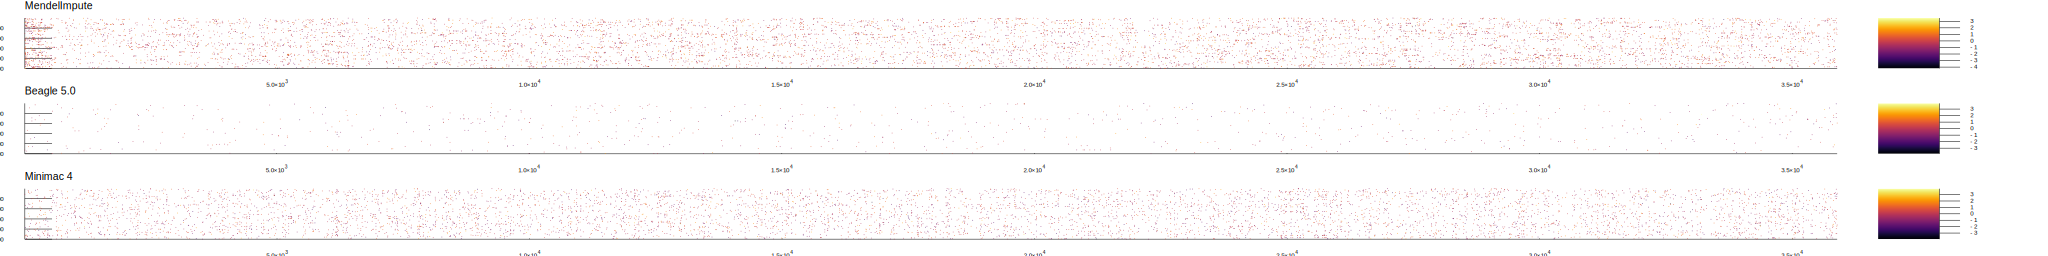

In [7]:
A = Plots.spy(mendel_disagreeing_entries, size=(4000,500), title="MendelImpute", title_location=:left)
B = Plots.spy(beagle_disagreeing_entries, size=(4000,500), title="Beagle 5.0", title_location=:left)
C = Plots.spy(minimac_disagreeing_entries, size=(4000,500), title="Minimac 4", title_location=:left)
plot(A, B, C, layout = (3, 1))

In [36]:
@show count(!iszero, mendel_disagreeing_entries[:, 1:400])
@show count(!iszero, mendel_disagreeing_entries[:, 401:800])
@show count(!iszero, mendel_disagreeing_entries[:, 801:1200])
@show count(!iszero, mendel_disagreeing_entries[:, 1201:1600])
@show count(!iszero, mendel_disagreeing_entries[:, 1601:2000])
@show count(!iszero, mendel_disagreeing_entries[:, 2001:2400])
# width = 400
# for i in 1:Int(ceil(size(X_complete, 2) / width)) - 1
#     println(count(!iszero, mendel_disagreeing_entries[:, (1 + 400(i - 1)):400i]))
# end

count(!iszero, mendel_disagreeing_entries[:, 1:400]) = 348
count(!iszero, mendel_disagreeing_entries[:, 401:800]) = 95
count(!iszero, mendel_disagreeing_entries[:, 801:1200]) = 64
count(!iszero, mendel_disagreeing_entries[:, 1201:1600]) = 87
count(!iszero, mendel_disagreeing_entries[:, 1601:2000]) = 70
count(!iszero, mendel_disagreeing_entries[:, 2001:2400]) = 67


67

# Error rate as a function of sample size

`full.vcf` contains 2000 samples, or 4000 haplotypes. Using this data, we randomly choose the last 100, 200, ..., 1900 samples as imputation targets and use the remaining haplotypes as reference panels. Then we compare the speed, memory, and accuracy of MendelImpute, Minimac4, and Beagle5 on these simulated datasets.

### First generate the different datasets

In [15]:
records, samples = nrecords("full.vcf"), nsamples("full.vcf")
for i in 1:19
    # compute target and reference index
    to_keep = 100i
    tgt_index = falses(samples)
    tgt_index[samples-to_keep+1:end] .= true
    ref_index = .!tgt_index
    record_index = trues(records) # save all records (SNPs) 

    # create target.vcf.gz and haplo_ref.vcf.gz
    tgtfile = "./compare1/$(to_keep)_target.vcf.gz"
    reffile = "./compare1/$(to_keep)_haplo_ref.vcf.gz"
    @time VCFTools.filter("full.vcf", record_index, tgt_index, des = tgtfile)
    @time VCFTools.filter("full.vcf", record_index, ref_index, des = reffile)

    # import full target matrix. Also transpose so that columns are samples. 
    @time X = convert_gt(Float32, tgtfile; as_minorallele=false)
    X = copy(X')

    # mask 10% entries
    p, n = size(X)
    Random.seed!(123)
    missingprop = 0.1
    X .= ifelse.(rand(Float32, p, n) .< missingprop, missing, X)
    masks = ismissing.(X)

    # save X to new VCF file
    mask_gt(tgtfile, masks, des="./compare1/$(to_keep)_target_masked.vcf.gz")
end

 18.239669 seconds (234.13 M allocations: 22.718 GiB, 15.19% gc time)
 40.032299 seconds (557.31 M allocations: 43.346 GiB, 13.34% gc time)
  0.520760 seconds (7.86 M allocations: 690.876 MiB, 21.26% gc time)
 18.806437 seconds (252.12 M allocations: 23.842 GiB, 15.23% gc time)
 39.840113 seconds (539.36 M allocations: 42.223 GiB, 13.37% gc time)
  0.962408 seconds (15.08 M allocations: 1.312 GiB, 13.27% gc time)
 19.772307 seconds (270.07 M allocations: 24.965 GiB, 14.63% gc time)
 36.901654 seconds (521.42 M allocations: 41.100 GiB, 13.88% gc time)
  1.395913 seconds (22.29 M allocations: 2.014 GiB, 16.38% gc time)
 21.279525 seconds (288.01 M allocations: 26.088 GiB, 15.01% gc time)
 35.330595 seconds (503.47 M allocations: 39.977 GiB, 13.63% gc time)
  2.171800 seconds (29.47 M allocations: 2.585 GiB, 18.65% gc time)
 25.166582 seconds (306.00 M allocations: 27.348 GiB, 14.81% gc time)
 36.509108 seconds (485.52 M allocations: 38.853 GiB, 13.61% gc time)
  2.290493 seconds (36.65 M

### Convert vcf to m3vcf on Hoffman (Julia 1.2)

Each takes ~5 min. This is needed because Minimac4 only runs their own M3VCF files (which requires Minimac3)

```Julia
for i in 1:19
    minimac3 = "/u/home/b/biona001/haplotype_comparisons/minimac3/Minimac3/bin/Minimac3"
    @time run(`$minimac3 --refHaps $(100i)_haplo_ref.vcf.gz --processReference --prefix $(100i)_haplo_ref`)
end
```

## Analyze:

In [54]:
mendel_1200_error   = zeros(19)
mendel_1200_times   = zeros(19) #sec
mendel_1200_mem     = zeros(19) #MB
for i in 1:19
    #
    # current run info
    #
    X_complete = convert_gt(Float32, "./compare1/$(100i)_target.vcf.gz"; as_minorallele=false)
    X_masked   = convert_gt(Float32, "./compare1/$(100i)_target_masked.vcf.gz"; as_minorallele=false)
    missing_idx = ismissing.(X_masked)
    total_missing = sum(missing_idx)
    actual_missing_values = X_complete[missing_idx]  #true values of missing entries
    #
    # MendelImpute (window = 1200)
    #
    tgtfile = "./compare1/$(100i)_target_masked.vcf.gz"
    reffile = "./compare1/$(100i)_haplo_ref.vcf.gz"
    outfile = "./compare1/$(100i)_mendel.result.vcf.gz"
    width   = 1200
    mendel_result = @timed phase(tgtfile, reffile, impute=true, outfile = outfile, width = width)
    X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
    imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
    mendel_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    mendel_1200_error[i] = mendel_err
    mendel_1200_times[i] = mendel_result[2] 
    mendel_1200_mem[i]   = mendel_result[3] / 1e6
end

In [37]:
mendel_error   = zeros(19)
mendel_times   = zeros(19) #sec
mendel_mem     = zeros(19) #MB
beagle5_error  = zeros(19)
beagle5_times  = zeros(19)
beagle5_mem    = zeros(19)
minimac4_error = zeros(19)
minimac4_times = zeros(19)
minimac4_mem   = zeros(19)
for i in 1:19
    #
    # current run info
    #
    X_complete = convert_gt(Float32, "./compare1/$(100i)_target.vcf.gz"; as_minorallele=false)
    X_masked   = convert_gt(Float32, "./compare1/$(100i)_target_masked.vcf.gz"; as_minorallele=false)
    missing_idx = ismissing.(X_masked)
    total_missing = sum(missing_idx)
    actual_missing_values = X_complete[missing_idx]  #true values of missing entries
    #
    # MendelImpute (window = 400)
    #
    tgtfile = "./compare1/$(100i)_target_masked.vcf.gz"
    reffile = "./compare1/$(100i)_haplo_ref.vcf.gz"
    outfile = "./compare1/$(100i)_mendel.result.vcf.gz"
    width   = 400
    mendel_result = @timed phase(tgtfile, reffile, impute=true, outfile = outfile, width = width)
    X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
    imputed_missing_values = X_mendel[missing_idx] #imputed values of missing entries
    mendel_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    mendel_error[i] = mendel_err
    mendel_times[i] = mendel_result[2] 
    mendel_mem[i]   = mendel_result[3] / 1e6
    #
    # Beagle 5
    #
    beagle_result = @timed run(`java -jar beagle.28Sep18.793.jar gt=./compare1/$(100i)_target_masked.vcf.gz ref=./compare1/$(100i)_haplo_ref.vcf.gz out=./compare1/$(100i)_beagle.result`)
    X_beagle = convert_gt(Float32, "./compare1/$(100i)_beagle.result.vcf.gz", as_minorallele=false)
    imputed_missing_values = X_beagle[missing_idx] #imputed values of missing entries
    beagle_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    beagle5_error[i] = beagle_err
    beagle5_times[i] = beagle_result[2]
    beagle5_mem[i]   = beagle_result[3] / 1e6
    #
    # minimac 4
    #
    minimac4 = "/Users/biona001/Benjamin_Folder/UCLA/research/softwares/Minimac4/build/minimac4"
    minimac_result = @timed run(`$minimac4 --refHaps ./compare1/$(100i)_haplo_ref.m3vcf.gz --haps ./compare1/$(100i)_target_masked.vcf.gz --prefix ./compare1/$(100i)_minimac4.result`)
    X_minimac = convert_gt(Float32, "./compare1/$(100i)_minimac4.result.dose.vcf.gz", as_minorallele=false)
    imputed_missing_values = X_minimac[missing_idx] #imputed values of missing entries
    minimac_err = sum(actual_missing_values .!= imputed_missing_values) / total_missing
    minimac4_error[i] = minimac_err
    minimac4_times[i] = minimac_result[2]
    minimac4_mem[i]   = minimac_result[3] / 1e6
end

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 01:22 AM PST on 11 Dec 2019

Command line: java -Xmx3641m -jar beagle.28Sep18.793.jar
  gt=./sample_size/100_target_masked.vcf.gz
  ref=./sample_size/100_haplo_ref.vcf.gz
  out=./sample_size/100_beagle.result

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       1,900
Study samples:             100

Window 1 (1:36-4999683)
Reference markers:      35,897
Study markers:          35,897

Burnin  iteration 1:           9 seconds
Burnin  iteration 2:           5 seconds
Burnin  iteration 3:           3 seconds
Burnin  iteration 4:           4 seconds
Burnin  iteration 5:           3 seconds
Burnin  iteration 6:           4 seconds

Phasing iteration 1:           2 seconds
Phasing iteration 2:           2 seconds
Phasing iteration 3:           2 seconds
Phasing iteration 4:           2 seconds
Phasing iteration 5

In [55]:
haplotype_reference_size = reverse(collect(200:200:3800))
sample_size = (4000 .- haplotype_reference_size) ./ 2
[sample_size mendel_error mendel_1200_error beagle5_error minimac4_error]

19×5 Array{Float64,2}:
  100.0  0.00221891  0.0023776   0.000203238  0.000139204
  200.0  0.00199824  0.00219166  0.000193423  0.000151677
  300.0  0.00207736  0.00236603  0.000194926  0.000160582
  400.0  0.00209315  0.00264185  0.000192882  0.000165725
  500.0  0.00216476  0.00258356  0.000203277  0.000182671
  600.0  0.00219264  0.00273848  0.000207763  0.000199879
  700.0  0.00231082  0.00301655  0.000325232  0.000222255
  800.0  0.00230644  0.0030015   0.000306829  0.000253256
  900.0  0.00237092  0.00357184  0.000355452  0.000292034
 1000.0  0.00237504  0.003796    0.000222999  0.000304014
 1100.0  0.00258552  0.00416094  0.000282526  0.000345563
 1200.0  0.0027198   0.00451528  0.000276924  0.000392058
 1300.0  0.00286455  0.00493401  0.000262245  0.000429576
 1400.0  0.00313687  0.00590106  0.000382832  0.000525101
 1500.0  0.00342885  0.00667756  0.00028193   0.00059302 
 1600.0  0.0039391   0.00811048  0.000361835  0.000764765
 1700.0  0.00495996  0.0108217   0.000301035  0.0

In [56]:
[sample_size mendel_times mendel_1200_times beagle5_times minimac4_times]

19×5 Array{Float64,2}:
  100.0  14.0551  14.9088   56.7424  151.583
  200.0  16.2895  18.4679   87.6731  211.091
  300.0  16.7011  19.5794  126.033   271.342
  400.0  18.8638  20.8112  143.121   327.088
  500.0  20.2512  22.8566  178.576   383.784
  600.0  22.5655  23.8698  207.525   428.037
  700.0  24.7581  28.3699  244.148   472.338
  800.0  26.3045  28.0556  266.5     502.989
  900.0  27.4628  32.357   294.07    562.578
 1000.0  28.8264  32.5215  322.526   560.161
 1100.0  30.4397  35.3225  354.228   578.269
 1200.0  31.9834  35.5846  391.811   586.907
 1300.0  32.9212  36.2763  414.914   589.967
 1400.0  34.4399  39.7434  442.836   586.003
 1500.0  35.168   39.3551  477.496   574.747
 1600.0  36.6773  40.5079  508.32    546.31 
 1700.0  37.6205  40.7102  541.092   506.69 
 1800.0  38.2893  41.0959  581.237   453.177
 1900.0  39.4661  43.7754  650.147   366.959

In [57]:
[haplotype_reference_size mendel_mem mendel_1200_mem beagle5_mem minimac4_mem] # the real memory usage is not correctly benchmarked in all 3 

19×5 Array{Float64,2}:
 3800.0  15532.2  15551.6  0.270384  0.291456
 3600.0  17149.8  17155.0  0.299632  0.34152 
 3400.0  18322.8  18322.4  0.339152  0.422752
 3200.0  19291.7  19286.8  0.343488  0.460464
 3000.0  20393.4  20376.3  0.375648  0.552896
 2800.0  22445.3  22450.0  0.398048  0.563216
 2600.0  24612.7  24580.7  0.447408  0.62712 
 2400.0  25746.6  25713.0  0.450192  0.652592
 2200.0  26698.5  26659.0  0.474176  0.728304
 2000.0  27054.0  27009.5  0.498496  0.718784
 1800.0  28604.7  28552.0  0.524752  0.742224
 1600.0  29547.8  29493.1  0.564912  0.753552
 1400.0  30495.1  30437.3  0.575632  0.782336
 1200.0  31441.0  31378.2  0.6024    0.768928
 1000.0  32094.8  32029.8  0.630352  0.781536
  800.0  33044.6  32975.0  0.655648  0.766336
  600.0  33981.5  33911.3  0.684736  0.735168
  400.0  34778.0  34704.6  0.720272  0.701008
  200.0  35650.6  35571.7  0.777568  0.659888

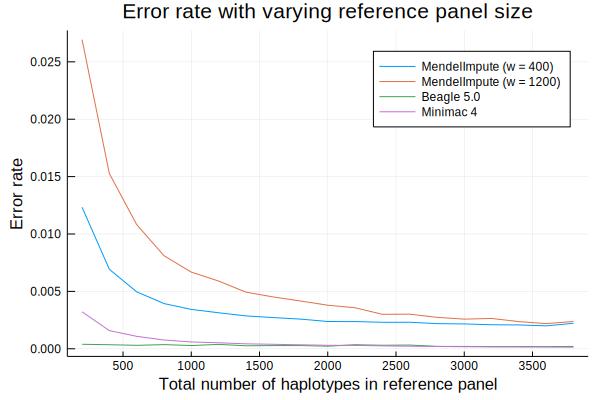

In [62]:
plot(haplotype_reference_size, [mendel_error mendel_1200_error beagle5_error minimac4_error],
    label = ["MendelImpute (w = 400)", "MendelImpute (w = 1200)", "Beagle 5.0", "Minimac 4"], 
    title = "Error rate with varying reference panel size",
    ylabel = "Error rate", xlabel = "Total number of haplotypes in reference panel")

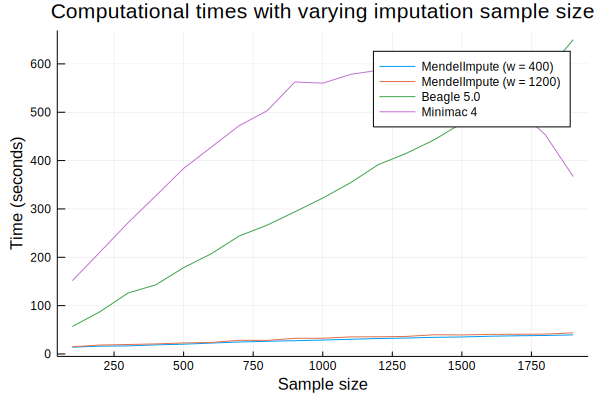

In [60]:
plot(sample_size, [mendel_times mendel_1200_times beagle5_times minimac4_times],
    label = ["MendelImpute (w = 400)", "MendelImpute (w = 1200)", "Beagle 5.0", "Minimac 4"], 
    title = "Computational times with varying imputation sample size",
    ylabel = "Time (seconds)", xlabel = "Sample size ")